## detect the fake profiles in online social networks using Neural Network

In [1]:
import sys
import csv
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_validate
from sklearn import metrics
from pybrain3.structure import SigmoidLayer
from pybrain3.datasets import ClassificationDataSet
from pybrain3.utilities import percentError
from pybrain3.tools.shortcuts import buildNetwork
from pybrain3.supervised.trainers import BackpropTrainer
from pybrain3.structure.modules import SoftmaxLayer
from pybrain3.tools.xml.networkwriter import NetworkWriter
from pybrain3.tools.xml.networkreader import NetworkReader
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline 


###### function for reading dataset from csv files

In [2]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

###### function for predicting sex using name of person

In [3]:
def predict_sex(name):
#     sex_predictor = gender.Detector(case_sensitive=False,unknown_value=u"unknown")
    first_name= name.str.split(' ').str.get(0)
#     sex_predictor = gender.Detector()
#     sex = sex_predictor.get_gender(first_name)
#     sex= first_name.apply(sex_predictor.get_gender)
#     sex = 'unknown'
#     sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = 0 
#     sex.map(sex_dict).astype(int)
    return sex_code

###### function for feature engineering

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

###### function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### function for plotting ROC curve

In [6]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print("False Positive rate: ",false_positive_rate)
    print("True Positive rate: ",true_positive_rate)


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Function for training data using Neural Network

In [7]:
def train(X,y):
    """ Trains and predicts dataset with a Neural Network classifier """

    ds = ClassificationDataSet( len(X.columns), 1,nb_classes=2)
    for k in range(len(X)): 
    	ds.addSample(X.iloc[k],np.array(y[k]))
    tstdata, trndata = ds.splitWithProportion( 0.20 )
    trndata._convertToOneOfMany( )
    tstdata._convertToOneOfMany( ) 
    input_size=len(X.columns)
    target_size=1
    hidden_size = 5   
    fnn=None
    if  os.path.isfile('fnn.xml'): 
    	fnn = NetworkReader.readFrom('fnn.xml') 
    else:
    	fnn = buildNetwork( trndata.indim, hidden_size , trndata.outdim, outclass=SoftmaxLayer )	
    trainer = BackpropTrainer( fnn, dataset=trndata,momentum=0.05, learningrate=0.1 , verbose=False, weightdecay=0.01)


    trainer.trainUntilConvergence(verbose = False, validationProportion = 0.15, maxEpochs = 100, continueEpochs = 10 )
    print(fnn)
    NetworkWriter.writeToFile(fnn, 'oliv.xml')
    predictions=trainer.testOnClassData (dataset=tstdata)
    return tstdata['class'],predictions 

In [8]:
print("reading datasets.....\n")
x,y=read_datasets()
x.describe()

reading datasets.....



,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,protected,verified
count,2.818000e+03,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,1728.0,8.0,721.0,2760.0,489.0,1069.000000,0.0,0.0
mean,5.374889e+08,1672.198368,371.105039,395.363023,234.541164,2.818666,1.0,1.0,1.0,1.0,1.0,1478.391020,NaN,NaN
std,2.977005e+08,4884.669157,8022.631339,465.694322,1445.847248,23.480430,0.0,0.0,0.0,0.0,0.0,8108.211889,NaN,NaN
min,3.610511e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN
25%,3.620867e+08,35.000000,17.000000,168.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
50%,6.162253e+08,77.000000,26.000000,306.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
75%,6.177673e+08,1087.750000,111.000000,519.000000,37.000000,1.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
max,1.391998e+09,79876.000000,408372.000000,12773.000000,44349.000000,744.000000,1.0,1.0,1.0,1.0,1.0,36000.000000,NaN,NaN


In [9]:
print("extracting featues.....\n");
x=extract_features(x);
print(x.columns)
print(x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count  sex_code    lang_code  
count   2818.000000    2818.0  2818.000000  
mean       2.818666       0.0     2.851313  
std       23

In [10]:
print("training datasets.......\n")
y_test,y_pred =train(x,y)

training datasets.......

FeedForwardNetwork-8
   Modules:
    [<BiasUnit 'bias'>, <LinearLayer 'in'>, <SigmoidLayer 'hidden0'>, <SoftmaxLayer 'out'>]
   Connections:
    [<FullConnection 'FullConnection-4': 'bias' -> 'out'>, <FullConnection 'FullConnection-5': 'bias' -> 'hidden0'>, <FullConnection 'FullConnection-6': 'hidden0' -> 'out'>, <FullConnection 'FullConnection-7': 'in' -> 'hidden0'>]



In [11]:
print('Classification Accuracy on Test dataset: ',accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.9449378330373002


In [12]:
print('Percent Error on Test dataset: ' ,percentError(y_pred,y_test))

Percent Error on Test dataset:  5.506216696269982


Confusion matrix, without normalization
[[249   4]
 [ 27 283]]


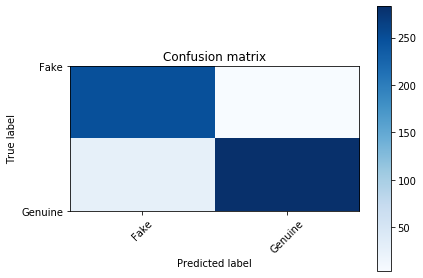

In [13]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.98418972 0.01581028]
 [0.08709677 0.91290323]]


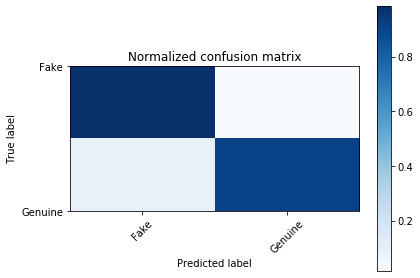

In [14]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [15]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.90      0.98      0.94       253
     Genuine       0.99      0.91      0.95       310

    accuracy                           0.94       563
   macro avg       0.94      0.95      0.94       563
weighted avg       0.95      0.94      0.95       563



In [16]:
s=roc_auc_score(y_test, y_pred)
print("roc_auc_score : ",s)

roc_auc_score :  0.9485464745633049


False Positive rate:  [0.         0.01581028 1.        ]
True Positive rate:  [0.         0.91290323 1.        ]


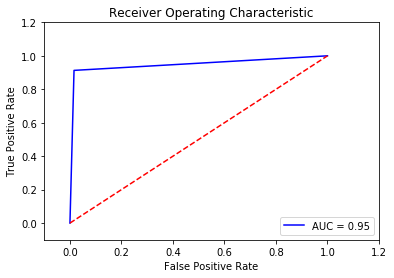

In [17]:
 plot_roc_curve(y_test, y_pred)